## Viewing the sat images and the mask ##

This set of code is for viewing the Sat images pre and post and showing the boxes around it

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
import json
import pathlib

In [3]:
xview_train_img_dir = "c:/data/xview2/train/images"
xview_train_json_dir = "c:/data/xview2/train/labels"

In [5]:
def show_pre_post(file, xview_train_img_dir, xview_train_json_dir):
    post_name = file + "_post_disaster"
    pre_name = file + "_pre_disaster"
    fig, ax = plt.subplots(1,2, figsize=(20,20))
    load_show(ax[0], xview_train_img_dir, xview_train_json_dir, pre_name)
    load_show(ax[1], xview_train_img_dir, xview_train_json_dir, post_name)
    plt.show()

def load_show(ax, img_path, json_path, name):
    image_path=os.path.join(img_path, name+".png")
    json_path = os.path.join(json_path, name+".json")
    j = json.loads(pathlib.Path(json_path).read_text())
    
    im = Image.open(image_path)
    
    #im.show()
    ax.imshow(im)
    
    polygons = extract_polygon(j)
    for p in polygons:
        ax.plot(p[0][0],p[0][1])

    
def plot_polygon(ax, x, y):
    ax.plot(x,y)
    
def extract_polygon(json):
    xy_f = json["features"]["xy"]
    results = []
    for i in xy_f:
        polygon_str = i["wkt"]
        r = decode_polygon(polygon_str)
        results.append((r, i)) if r is not "" else ""
    return results

def decode_polygon(polygon_str):
    if polygon_str.startswith("POLYGON"):
        replace_str = ["POLYGON", "((", "))", ","]
        for rs in replace_str:
            polygon_str = polygon_str.replace(rs,"")
        x_y = polygon_str.strip().split(" ")
        x = list(map(lambda x:float(x), x_y[0::2]))
        y = list(map(lambda x:float(x), x_y[1::2]))
        return [x,y]
    else:
        print("Unknown Shape")
        return ""
    
def create_mask(picture, polygons):
    im = Image.open(picture)
    np.array(im.size)
    
            
    
c = decode_polygon("POLYGON ((532.1863714054954 165.9824503000504, 548.6019827848852 224.1613082732768, 446.2458177229872 264.4761185678668, 440.6934785817455 249.7503495372735, 425.9677095499687 253.1300342329752, 420.8981825090282 232.3691139606, 437.5551999358392 227.0581808684396, 431.2786426428399 201.2277335525121, 532.1863714054954 165.9824503000504))")


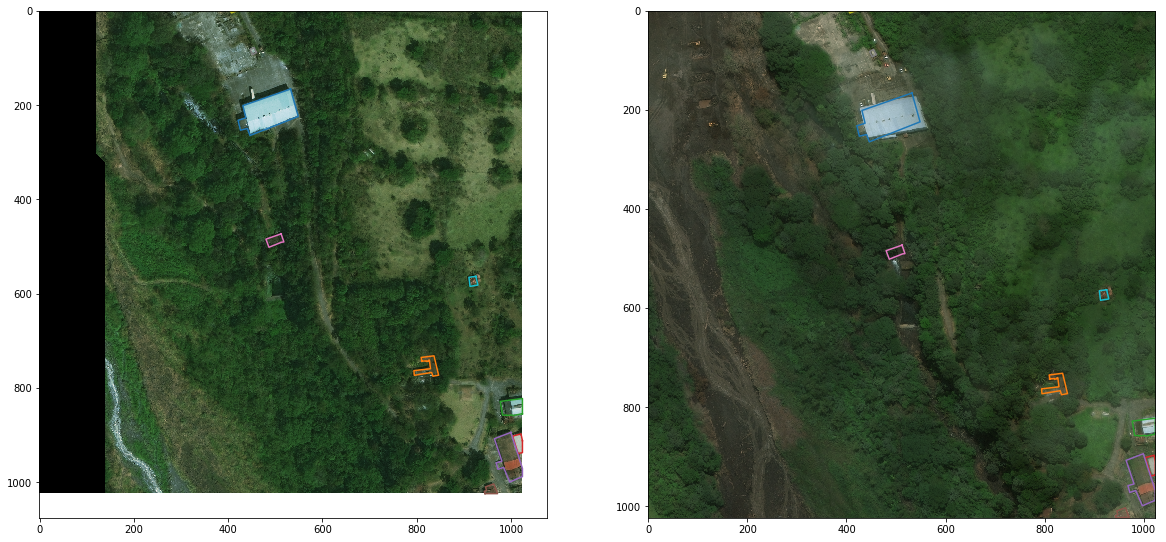

In [7]:
show_pre_post("guatemala-volcano_00000000", xview_train_img_dir, xview_train_json_dir)

In [ ]:
show_pre_post("hurricane-florence_00000199", xview_train_img_dir, xview_train_json_dir)

[[810.6063105745833, 809.2415595562098, 836.3546131212291, 846.180820453518, 834.1710114918316, 831.4415094550847, 794.6842153602263, 793.8653647492023, 828.9849576220124, 826.7103725913901, 824.7087377644423, 824.6177543632174, 820.2505511044224, 819.7046506970729, 810.6063105745833], [743.0540226914463, 735.1384667848803, 731.7720809395591, 772.8055948919877, 774.9891965213851, 766.9826572135942, 773.0785450956623, 763.1613543621486, 759.1580847082531, 740.688454259599, 741.3253380681733, 743.0540226914463, 743.6909065000207, 742.508122284097, 743.0540226914463]]


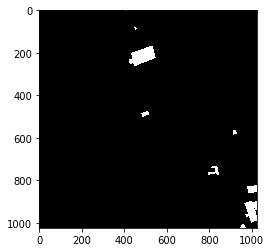

In [16]:
from skimage.draw import polygon 
im = Image.open(os.path.join(xview_train_img_dir,"guatemala-volcano_00000000_pre_disaster.png"))
im.size
arr = np.zeros(im.size)


j = json.loads(pathlib.Path(os.path.join(xview_train_json_dir,"guatemala-volcano_00000000_pre_disaster.json")).read_text())
r = map(lambda x: x[0], extract_polygon(j))
x_y=list(r)
print(x_y[1])

for i in x_y:
    #plt.plot(i[0], i[1])
    #plt.fill(i[0], i[1])
    xs, ys = polygon(i[1],i[0])
    arr[xs,ys]=255
plt.imshow(arr, cmap="gray")
plt.imsave("mask.png",arr, cmap="gray")